# Принятие решений в бизнесе. А/В тест.
# Введение

В данном проекте рассматривается: 
- Приоритизация гипотез при помощи метода `WSJF` (алгоритмы `ICE` и `RICE`). 
Будут рассммотрены 9 гипотез, которые будут отсортированы по приоритетности исполнения. 

- Анализ и интерпретация A/B теста. 
Будут изучены результаты A/B теста с 2 группами: контрольной (`A`) и экспериментальной (`B`).


В ходе работы были проверены следующие кумулятивные метрики: 
- Кумулятивная выручка по группам;
- Кумулятивный средний чек по группам;
- Относительное изменение кумулятивного среднего чека группы B к группе A;
- Кумулятивная конверсия по группам;
- Оносительное изменение кумулятивной конверсии группы B к группе A. 

и проведен непараметрический тест U-критерий Манна-Уитни для расчета статистической значимости: 
-  Различий в конверсии и среднем чеке заказа между группами по «сырым» данным;
-  Различий в конверсии и среднем чеке заказа между группами по «очищенным» данным.

По результатам проведенного исследования была проведена оценка A/B теста и вывод о его результатах.

Срок проведения теста - 1 календарный месяц (01.08-01.09.2019 г.)

### Загрузка данных

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import scipy.stats as stats
from matplotlib import pyplot as plt

In [2]:
try:
    hypothesis = pd.read_csv(r'C:\Users\newsl\datasets\hypothesis.csv')
    orders = pd.read_csv(r'C:\Users\newsl\datasets\orders.csv')
    visitors = pd.read_csv(r'C:\Users\newsl\datasets\visitors.csv')
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

# I часть. Приоритизация гипотез.
Займемся приоритизацией гипотез. В датафрейм `hypothesis` были выгружены 9 гипотез для увеличения выручки интернет-магазина. Для приоритизации используем метод `WSJF`, позволяющий оценить задачи более детально и рассортировать гипотезы по их приоритету. 
Каждой гипотезе присвоено 4 параметра оценки: 
- Reach — скольких пользователей затронет изменение, которое вы хотите внести;
- Impact — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
- Confidence — насколько вы уверены, что это изменение повлияет на пользователей именно так;
- Efforts — сколько стоит протестировать эту гипотезу

Для приоритизации будем использовать фреймворки `ICE` и `RICE`, но для начала выгрузим датафрейм и посмотрим на него. 
В датафрейме `hypothesis`: 4 столбца с оценками и 9 строк с гипотезами, пропуски отсутствуют. Переведем названия столбцов для удобства в нижний регистр и замемся непосредственно приоритизацией: 

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
hypothesis.columns = [x.lower() for x in hypothesis.columns]
pd.options.display.max_colwidth = 1
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Начнем с фреймворка `ICE`:
`ICE = (impact * confidence) / efforts`

Здесь мы оцениваем отношение, насколько мы уверены, что изменение повлияет на пользователей и именно так, как мы рассчитывали, к стоимости внедрения такой гипотезы. Т.е. на первый план при оценке `ICE` выходят те гипотезы, внедрение которых максимально влияет на пользователей, при этом стоимость такого изменения- минимальна. 
Видно, что ТОП-2 гипотез следующий: 
- 8	Запустить акцию, дающую скидку на товар в день рождения: `ICE = 16.20`,
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей : `ICE = 13.33`, 
- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок: `ICE = 11.20`

Эти гипотезы требуют средних денежных и временных затрат на их внедрение, однако оказывают большое влияние на пользователей. Поэтому их приоритет `ICE` максимален и при таком способе подсчета данные гипотезы являются наиболее приоритетными для внедрения. 

In [5]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis.sort_values(by = 'ICE', ascending = False)[['hypothesis', 'ICE']])

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Проверим эти же гипотезы по фреймворку `RICE`: `RICE = (reach * impact * confidence) / efforts`

При таком способе расчета мы также оцениваем, какое количество пользователей затронет наша гипотеза - чем большее, тем выше показатель `reach`.
Видно, что при оценке `RICE` ТОП-3 гипотез изменился: 
- 7 Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок: `RICE = 112.0`;
- 2 Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа: `RICE = 56.0`;
- 0 Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей : `RICE = 40.0`

На первое место уверенно вышла гипотеза 7, которая затрагивает абсолютно всех пользователей, а стоимость ее внедрения - средняя. Именно поэтому ее приоритет выше всего. 
На второе место вышла гипотеза 2, которая также затрагивает всех пользователей и имеет низкую стоимость внедрения. 
Третье место - гипотеза 0 (небольшой охват пользователей, но остальные параметры довольно высоки). 

В ТОП-3 `ICE` и `RICE` попали гипотезы 0 и 7. 
А вот 8 и 2 попали только в один из рейтингов и вот почему: 
- 8: очень низкий показатель охвата пользователей - ТОП-3 `ICE`, 
- 2: наоборот, высокий показатель охвата `reach`, но низкий показатель изменений для пользователей `impact` - ТОП-3 `RICE`

Таким образом, гипотезы могут менять приоритет в зависимости от метода оценки и подсчета - `ICE` или `RICE`

In [6]:
hypothesis['RICE'] = round((hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts'], 2)
display(hypothesis.sort_values(by = 'RICE', ascending = False)[['hypothesis', 'RICE']])

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


# II часть. Анализ A/B-теста.
Займемся анализом результатов А/В теста и интерпретацией результата. 
Загрузим датафреймы `orders` (информация о заказах) и `visitors` (информация о визитах). В обоих датафреймах данные занесены верно, колонки названы корректно, пропусков нет. Изменим столбцы `date` на формат даты и можем приступать к обработке данных. 
Здесь и далее группа `A` - контрольная (без изменений), `B` - группа, при помощи которой подтверждали гипотезу.

In [7]:
orders.info()
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [8]:
visitors.info()
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Если мы посмотрим на вывод `info()` обоих датафреймов, то увидим, что пропуски значений отсутствуют. Проверим, есть ли дубликаты в таблицах, а также посмотрим, не попали ли какие-то пользователи в обе группы исследования одновременно. 

In [9]:
orders.loc[orders.duplicated()]

,transactionId,visitorId,date,revenue,group


In [10]:
visitors.loc[visitors.duplicated()]

,date,group,visitors


In [11]:
orders_usersA = orders.query('group == "A"')[['transactionId', 'visitorId']]
orders_usersB = orders.query('group == "B"')[['transactionId', 'visitorId']]

In [12]:
# код ревьюера
orders_usersA['visitorId'].isin(orders_usersB['visitorId']).sum()

89

Как видно, между столбцами `visitorId` в группах `A` и `B` есть пересечения. Найдем ID уникальных пользователей в каждой группе, при помощи множеств найдем пересечения этих ID. 
Как видно, в таблице `orders` 58 пересекающихся `visitorId`, всего строк с такими `visitorId` в таблице `orders`- 181. 
Я считаю, что подобные спорные `visitorId` - они противоречат самой сути A/B теста, где одно из главных условий- пользователи не должны пересекаться. 

In [13]:
visitors_A = orders_usersA['visitorId'].unique()
visitors_B = orders_usersB['visitorId'].unique()
result=list(set(visitors_A) & set(visitors_B))
print(len(result))
len(orders.query('visitorId in @result'))

58


181

In [14]:
orders = orders.query('not(visitorId in @result)')
len(orders)

1016

In [15]:
orders_usersA = orders.query('group == "A"')[['transactionId', 'visitorId']]
orders_usersB = orders.query('group == "B"')[['transactionId', 'visitorId']]
orders_usersA['visitorId'].isin(orders_usersB['visitorId']).sum()

0

К сожалению, после удаления пересекающихся пользователей, таблица потеряла около 15% данных (`1197/1016` строк), однако теперь данные корректные и готовы к анализу. 

## Анализ кумулятивных метрик
Проведем анализ кумулятивных метрик. Это необходимо для того. чтобы исключите проблему "подсматривания". Для этого мы исследуем накопительные данные за все время теста и построим графики. 

Для анализа создадим таблицу с кумулятивными данными. 
Сначала создадим датафрейм `date_groups` c уникальными парами "дата-группа", затем получим из таблицы `orders` даты меньшие, чем в таблице `date_groups` и сагрегируем данные: 
- Дата,
- Группа исследования,
- Количество уникальных заказов, 
- Количество уникальных покупателей, 
- Сумма заказов. 

То же самое сделаем с датафреймом `visitors` и получим следующие столбцы: 
- Дата,
- Группа исследования,
- Количество уникальных посетителей. 

Сщединим полученные кумулятивные таблицы в одну `cumulative_data` по парам "дата-группа" и на ее основе будем строить кумулятивные графики.

In [16]:
date_groups = orders[['date', 'group']].drop_duplicates()
date_groups

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A
...,...,...
1068,2019-08-12,A
1114,2019-08-13,B
1116,2019-08-13,A
1149,2019-08-14,B


In [17]:
orders_agg = date_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
orders_agg.head()

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854


In [18]:
visitors_agg = date_groups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])  
visitors_agg.head() 

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [19]:
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


### Анализ кумулятивной выручки по группам А/B
Рассморим графики кумулятивной выручки в группах. 
Для этого разделим `cumulative_data` на 2 датафрейма по группам анализа и построим графики кумулятивной выручки по каждой из групп. 

В ходе эксперимента кумулятивная выручка неуклонно растет, что неплохо.
Видно, что в первые 12 дней проведения эксперимента кумулятивная выручка в группах была приблизительно одинакова, хоть группа `А` и немного отставала по выручке. На 13 день кумулятивная выручка сравнялась, однако далее выручка в группе `В` стала расти намного быстрее и к концу эксперимента окончательно обогнала группу `А`. Возможно, имеют место какие-то дорогие нетипичные заказы в группе `В`, сделанные на 18й день эксперимента. Были ли подобные выбросы- проверим далее.

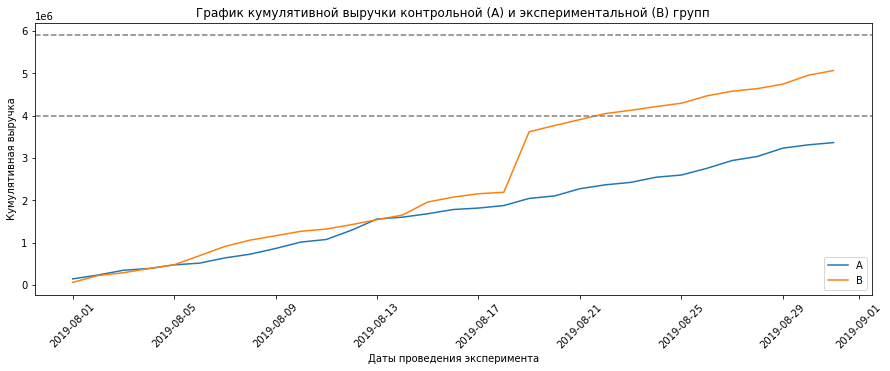

In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenueA = cumulative_data[cumulative_data['group'] == 'A'][['date', 'revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenueB = cumulative_data[cumulative_data['group'] == 'B'][['date','revenue', 'orders']]

fig = plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue'], label = 'A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue'], label = 'B')
plt.xticks(rotation = 45)
plt.axhline(y=4000000, color='grey', linestyle='--') 
plt.axhline(y=5900000, color='grey', linestyle='--')
plt.title('График кумулятивной выручки контрольной (А) и экспериментальной (В) групп')
plt.xlabel('Даты проведения эксперимента')
plt.ylabel('Кумулятивная выручка')
              
plt.legend() 

### Анализ кумулятивного среднего чека по группам А/B

Для анализа среднего чека поделим в каждой группе сумму заказов на их количество и построим график кумулятивного среднего чека. 
Видно, что в ходе всего эксперимента группа `В` обгоняет контрольную и кривая среднего чека неуклонно растет. Однако также на 18 день (как и в предыдущем графике), произошел скачок среднего чека. Видимо, имеет место быть выброс в виде крупного заказа в этот день, как мы и предполагали.
Контрольная группа `А` нестабильна: на 6й день средний чек снизился до минимума, затем стал расти и после 13 дня оставался относительно стабильным, без скачков. 

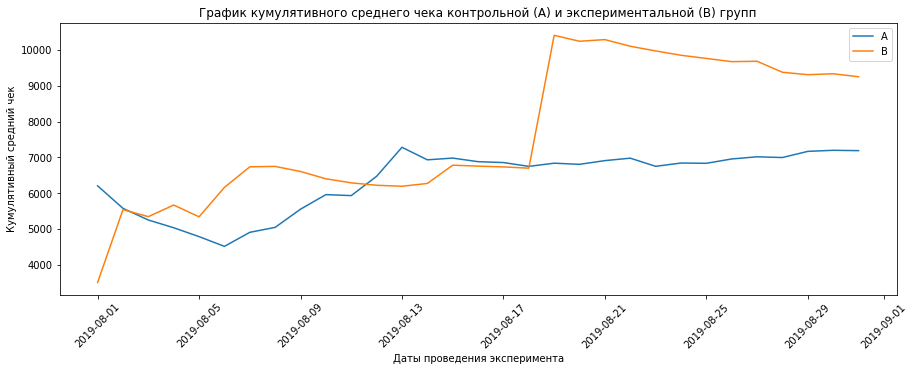

In [21]:
fig = plt.figure(figsize=(15, 5))
plt.plot(cumulative_revenueA['date'], cumulative_revenueA['revenue']/cumulative_revenueA['orders'], label = 'A')
plt.plot(cumulative_revenueB['date'], cumulative_revenueB['revenue']/cumulative_revenueB['orders'], label = 'B')
plt.xticks(rotation = 45)
plt.title('График кумулятивного среднего чека контрольной (А) и экспериментальной (В) групп')
plt.xlabel('Даты проведения эксперимента')
plt.ylabel('Кумулятивный средний чек')

plt.legend() 

### Анализ относительного изменения кумулятивного среднего чека группы B к группе A
Для того, чтобы выяснить, каково относительное изменение чека в экспериментальной группе `B` относительно контрольной группы `A`, найдем отношение В/А и построим график изменений. 
Видно, что: 
- Практически везде средний чек группы В выше чем у группы А (график находится выше 0),
- Средний чек группы В ниже только в 1 день эксперимента и с 10 по 14 день, 
- График растет неравномерно, видны скачки на 2, 5 и 18 день. 

Этот график подтверждает мое предположение о наличии крупных заказов-выбросов, которые влияют на ход эксперимента. 

Text(0, 0.5, 'Отношение кумулятивного среднего чека групп B/A')

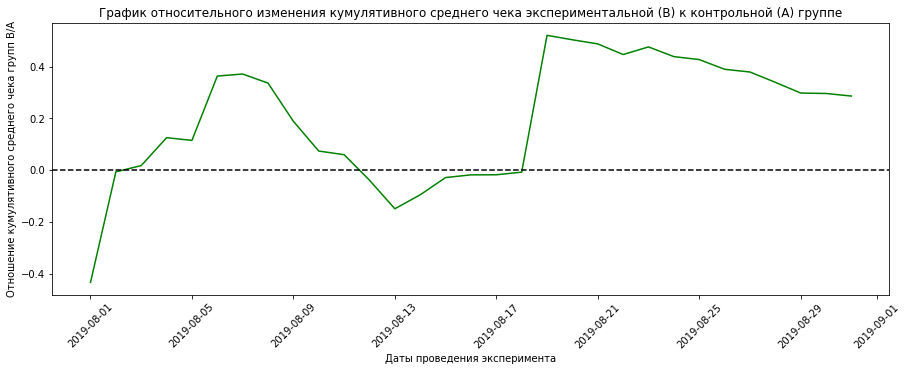

In [22]:
# собираем данные в одном датафрейме
merg_cumulative_revenue = cumulative_revenueA.merge(cumulative_revenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
fig = plt.figure(figsize=(15, 5))
plt.plot(merg_cumulative_revenue['date'], (merg_cumulative_revenue['revenueB']/merg_cumulative_revenue['ordersB'])/
         (merg_cumulative_revenue['revenueA']/merg_cumulative_revenue['ordersA'])-1, color = 'green')
plt.xticks(rotation = 45)  
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 

plt.title('График относительного изменения кумулятивного среднего чека экспериментальной (В) к контрольной (А) группе')
plt.xlabel('Даты проведения эксперимента')
plt.ylabel('Отношение кумулятивного среднего чека групп B/A')           

### Анализ кумулятивной конверсии по группам А/B

Рассмотрим кумулятивную конверсию в контрольной (`А`) и экспериментальной (`В`) группах. 
Для этого в датасете `cumulative_data` рассчитаем конверсию, а затем создадим из этой таблицы 2 датасета с информацией о конверсии в каждой из групп. 
Видно, что примерно после недели эксперимента конверсия обеих групп зафиксировалась и находится в относительном равновесии. График симметричен относительно `y = 0.0285` - кумулятивная конверсия группы В после недели эксперимента находится выше этой линии (0.030-0.032), конверсия группы `А` - ниже (0.027-0.025). 
На первой неделе эксперимента конверсия группы `В` ощутимо меньше, чем у группы `А`, однако после недели она выровнялась и обогнала группу `А`. У контрольной же группы `А` конверсия сначала росла, достигла пика на 3-4 день (возможно, имела место какая-либо рекламная кампания в эти дни), а затем пошла на спад. Для анализа различия конверсии между группами построим график относительного различия кумулятивных конверсий. 

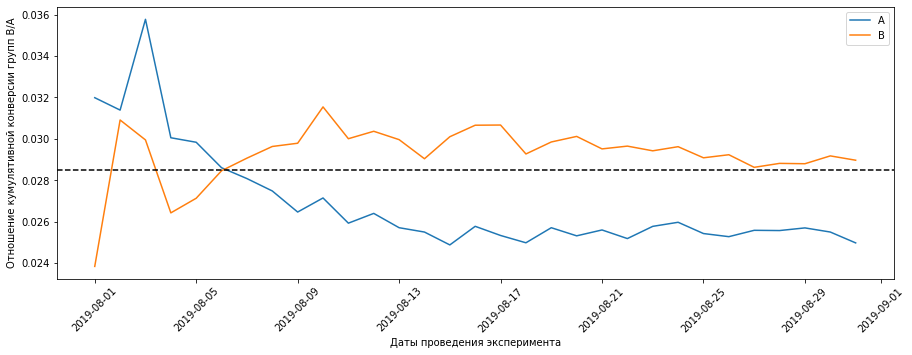

In [23]:
cumulative_data['conversion'] = cumulative_data['orders'] / cumulative_data['visitors']
cumulative_conversionA = cumulative_data[cumulative_data['group'] == 'A']
cumulative_conversionB = cumulative_data[cumulative_data['group'] == 'B']

fig = plt.figure(figsize=(15, 5))
plt.plot(cumulative_conversionA['date'], cumulative_conversionA['conversion'], label='A')
plt.plot(cumulative_conversionB['date'], cumulative_conversionB['conversion'], label='B')
plt.xticks(rotation = 45)
plt.axhline(y=0.0285, color='black', linestyle='--') 

plt.xlabel('Даты проведения эксперимента')
plt.ylabel('Отношение кумулятивной конверсии групп B/A') 
plt.legend()

### Анализ  относительного изменения кумулятивной конверсии группы B к группе A.

Изучим график относительного прироста конверсии экспериментальной группы к контрольной. По графику видно, что практически всю первую неделю эксперимента конверсия группы `В` была ниже, нежели у группы `А`. Однако затем ситуация улучшилась и конверсия группы `В` стала расти относительно контрольной группы, далее конверсия зафиксировалась на уровне +(11-16)% группы В относительно группы `А`. 
Хотелось бы на сделать вывод о том, что эксперимент удался и экспериментальная группа `В` вырвалась вперед, однако стоит учесть возможные аномалии в обеих группах. 

Text(0, 0.5, 'Прирост конверсии групп B/A')

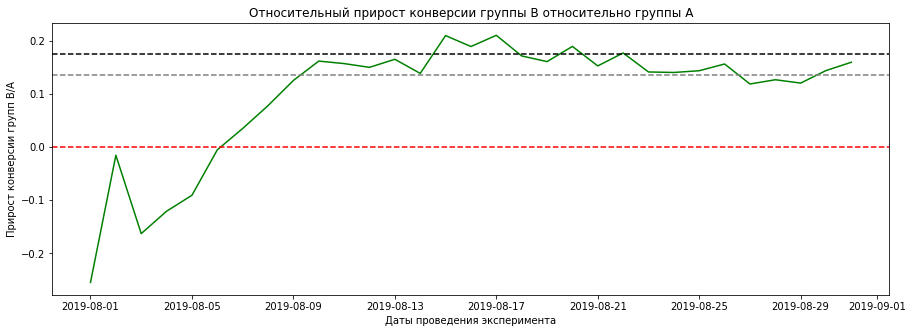

In [24]:
merg_cumulative_conv = cumulative_conversionA[['date','conversion']].merge(cumulative_conversionB[['date','conversion']], 
                                                    left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

fig = plt.figure(figsize=(15, 5))
plt.plot(merg_cumulative_conv['date'], merg_cumulative_conv['conversionB']/merg_cumulative_conv['conversionA']-1, color = 'green')
plt.title('Относительный прирост конверсии группы B относительно группы A')

plt.axhline(y=0.175, color='black', linestyle='--')
plt.axhline(y=0.135, color='grey', linestyle='--')
plt.axhline(y=0, color='red', linestyle='--')

plt.xlabel('Даты проведения эксперимента')
plt.ylabel('Прирост конверсии групп B/A') 

## Анализ выбросов

Проведем анализ возможных выбросов и посмотрим, присутствуют ли выбросы в данных и какова граница этих выбросов. Для этого проанализируем данные о количестве и стоимости заказов пользователей.

### Анализ количества заказов по пользователям
Проанализируем заказы пользователей - для этого посчитаем количество заказов `orders_count` и сумму покупок `orders_sum` для каждого пользователя. Чтобы определить границу аномалий по количеству заказов и сумме, найдем 95 и 99 перцентиль для каждого из параметров. <a id='orders_users'></a>

In [25]:
orders_users = orders.groupby('visitorId').agg({'transactionId':'nunique', 'revenue':'sum'})
x_range = pd.Series(range(0, len(orders_users)))
orders_users.columns = ['orders_count', 'orders_sum']
orders_users.head()

,orders_count,orders_sum
visitorId,,
5114589,1,570
6958315,1,1490
11685486,1,6201
39475350,1,3990
47206413,1,730


In [26]:
print(np.percentile(orders_users['orders_count'], [95, 99]))
print(np.percentile(orders_users['orders_sum'], [95, 99]))

[1. 2.]
[28910. 59082.]


Если проанализировать значения 95 и 99 перцентилей, то можно сказать:  <a id='trash'></a>
- 95% пользователей делают 1 заказ и только 1% пользователей делает 2 и более заказа.
- 95% пользователей покупают на общую сумму менее 28910.0 и только 1% пользователей купили на сумму более 59082.0

Значения выше 95 перцентиля будем считать выбросами, т.к. они искажают общую картину, но являются очень малочисленными, чтобы по ним можно было составить общую картину. Если мы посмотрим на точечный график количества и стоимости заказов по пользователям, то можно заметить, что большая часть значений располагается ниже линии 95 перцентиля. Выше линии 95 (и тем более 99) перцентиля- единичные значения. 

Перейдем к расчету статистической значимости различий по исходным данным, а также по данным, очищенным от выбросов. За выбросы примем значения за границей 95 перцентиля. 

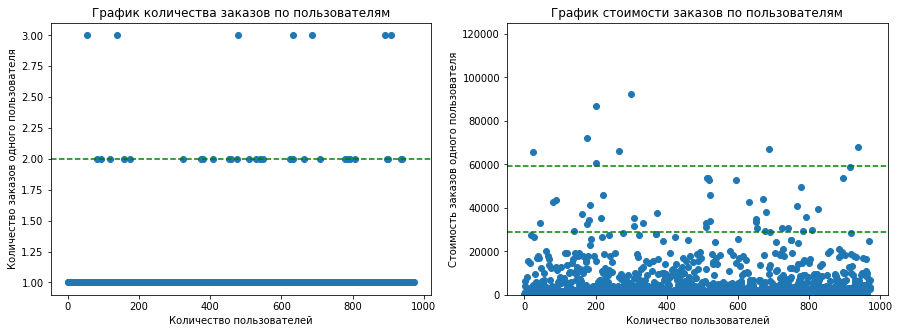

In [27]:
fig = plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
plt.scatter(x_range, orders_users['orders_count'])
plt.axhline(y=2, color='green', linestyle='--')
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов одного пользователя')

ax2 = plt.subplot(1, 2, 2)
plt.scatter(x_range, orders_users['orders_sum'])
plt.axhline(y=28910, color='green', linestyle='--')
plt.axhline(y=59082, color='green', linestyle='--')
plt.ylim(0, 125000)
plt.title('График стоимости заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов одного пользователя')

plt.show()

## Расчет статистической значимости различий между группами

Проведем расчет статистической значимости метрик в контрольной и экспериментальной группах. Расчет будем вести как по "сырым" исходным данным, так и по данным, "очищенным" от выбросов. 
Для начала создадим сводную таблицу `data` со обычными и накопитиельными данными по обеим группам: 

In [28]:
visitorsA_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']].sort_values(by = 'date')
visitorsA_daily.columns = ['date', 'visitorsPerDateA']

visitorsB_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']].sort_values(by = 'date')
visitorsB_daily.columns = ['date', 'visitorsPerDateB']

visitorsA_cumm = visitors_agg[visitors_agg['group'] == 'A']
visitorsA_cumm = visitorsA_cumm[['date', 'visitors']].sort_values(by = 'date')
visitorsA_cumm.columns = ['date', 'visitorsCummulativeA']

visitorsB_cumm = visitors_agg[visitors_agg['group'] == 'B']
visitorsB_cumm = visitorsB_cumm[['date', 'visitors']].sort_values(by = 'date')
visitorsB_cumm.columns = ['date', 'visitorsCummulativeB']

ordersA_daily = orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', 
                as_index = False).agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}).sort_values(by = 'date')
ordersA_daily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersB_daily = orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']].groupby('date', 
                as_index = False).agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'}).sort_values(by = 'date')
ordersB_daily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersA_cumm = orders_agg[orders_agg['group'] == 'A'][['date', 'transactionId', 'revenue']].sort_values(by = 'date')
ordersA_cumm.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']

ordersB_cumm = orders_agg[orders_agg['group'] == 'B'][['date', 'transactionId', 'revenue']].sort_values(by = 'date')
ordersB_cumm.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

data = (
    ordersA_daily.merge(
        ordersB_daily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersA_cumm, left_on='date', right_on='date', how='left')
    .merge(ordersB_cumm, left_on='date', right_on='date', how='left')
    .merge(visitorsA_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsB_daily, left_on='date', right_on='date', how='left')
    .merge(visitorsA_cumm, left_on='date', right_on='date', how='left')
    .merge(visitorsB_cumm, left_on='date', right_on='date', how='left')
)
data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Сделаем выборку по числу заказов каждого пользователя в группах - `SampleA`, `SampleB`. 

In [29]:
orders_by_usersA = orders[orders['group'] == 'A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_usersA.columns = ['userId', 'orders']

orders_by_usersB = orders[orders['group'] == 'B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
orders_by_usersB.columns = ['userId', 'orders']

sampleA = pd.concat([orders_by_usersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - 
                                                    len(orders_by_usersA['orders'])), name='orders')],axis=0)
sampleB = pd.concat([orders_by_usersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - 
                                                    len(orders_by_usersB['orders'])), name='orders')],axis=0)

### Cтатистическая значимость различий в конверсии между группами по «сырым» данным

Для расчета статистической значимости конверсии между выборками применим непараметрический тест U-критерий Манна-Уитни к выборкам `SampleA`, `SampleB`.
Для расчетов примем `p-value = 0.05`.
Т.к. в ходе исследования графики показывали, что конверсия экспериментальной группы `В` выше, чем у контрольной группы `А`, проверим статистическое различие конверсий между группами.

**Нулевая гипотеза Н0:** Статистических различий в конверсии между группами А и В нет. 

**Альтернативная гипотеза Н1:** Статистические различия в конверсии между группами А и В есть.

In [30]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.5f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01102
0.15980


Видно, что отвергается нулевая гипотеза в сторону альтернативной- статистические различия между группами присутствуют (результат теста меньше `p-value = 0.05`). Второй тест показывает нам, что статистическая разница между группами в пользу группы `B` - практически 16%. Это довольно большой прирост конверсии. Проверим, есть ли различия в среднем чеке между группами.

### Cтатистическая значимость различий среднего чека между группами по «сырым» данным

При помощи того же теста проверим различия среднего чека между группами А и В. Здесь опять же предположим, что экспериментальная группа опережает контрольную. 

**Нулевая гипотеза Н0:** Статистических различий в среднем чеке между группами А и В нет. 

**Альтернативная гипотеза Н1:** Статистические различия в среднем чеке между группами А и В есть.

In [31]:
print('{0:.5f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                          orders[orders['group']=='B']['revenue'])[1]))
print('{0:.5f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.82949
0.28660


Значение теста значительно больше `p-value = 0.05`, это значит, что нулевая гипотеза об отсутствии различий в среднем чеке подтверждается. Однако согласно второму тесту, средний чек группы `B` примерно на 28% выше, чем у группы `А`. 
Выше я изучала выбросы в "сырых" данных. Очистим данные от выбросов и изучим, как изменились результаты статистического теста.
Применим к очищенным данные те же самые гипотезы, что мы проверяли ранее. 

### Очистка данных от выбросов

На основании [данных](#trash), полученных в главе "Анализ выбросов", очистим данные от выбросов и установим границу выбросов на уровне 95 процентиля по количеству и сумме заказов. 

**95 перцентиль:**
- для количества заказов: 1,
- для суммы заказов: 28910.0. 

Используем таблицу [`orders_users`](#orders_users), где уже было посчитано количество и сумма заказов каждого пользователя и найдем пользователей с аномальными заказами. Как видно, таких пользователей 79 шт. Создадим выборки `SampleA_filt`, `SampleB_filt` для очищенных данных. 

In [32]:
users_many_orders = pd.concat([orders_by_usersA[orders_by_usersA['orders'] > 1]['userId'],
                               orders_by_usersB[orders_by_usersB['orders'] > 1]['userId'],],axis=0,)
users_expensive_orders = orders[orders['revenue'] > 28910]['visitorId']
anomal_users = pd.concat([users_many_orders, users_expensive_orders], axis=0).drop_duplicates().sort_values()

print(len(anomal_users))

79


In [33]:
sampleA_filt = pd.concat([np.logical_not(orders_by_usersA['orders'].isin(anomal_users)),pd.Series(0, 
                index=np.arange(data['visitorsPerDateA'].sum() - len(orders_by_usersA['orders'])), name='orders')],axis=0)
sampleB_filt = pd.concat([np.logical_not(orders_by_usersB['orders'].isin(anomal_users)),pd.Series(0, 
                index=np.arange(data['visitorsPerDateB'].sum() - len(orders_by_usersB['orders'])), name='orders')],axis=0)

In [34]:
sampleB_filt.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

### Cтатистическая значимость различий в конверсии между группами по «очищенным» данным

Проверим различия в конверсии по "очищенным" данным - выборки `SampleA_filt`, `SampleB_filt`
Для расчетов примем `p-value = 0.05`. Гипотезы оставим неизменными: 

**Нулевая гипотеза Н0:** Статистических различий в конверсии между группами А и В нет. 

**Альтернативная гипотеза Н1:** Статистические различия в конверсии между группами А и В есть.

In [35]:
print("{0:.5f}".format(stats.mannwhitneyu(sampleA_filt, sampleB_filt)[1]))

print("{0:.5f}".format(sampleB_filt.mean() / sampleA_filt.mean() - 1))

0.01093
0.17523


Здесь так же, как и ранее, нулевая гипотеза была отвергнута в сторону альтернативной - различия в конверсии есть, результат теста намного меньше `p-value`. Результаты теста по "сырым" и "очищенным" данным различаются незначительно (`0.01102/0.01093`), однако после удаления выбросов изменилось статистическая разница между экспериментальной и контрольной группой (`0.16/0.175`). Это значит, что выбросы влияли на средние значения конверсии и увеличивали значение по контрольной группе. После удаления выбросов среднее значение по группе `A` уменьшилось, что дало бОльшие различия в средней конверсии между группами. 

### Cтатистическая значимость различий среднего чека между группами по «очищенным» данным

Также проверим различия среднего чека между группами А и В по очищенным данным. Гипотезы оставим неизменными

**Нулевая гипотеза Н0:** Статистических различий в среднем чеке между группами А и В нет. 

**Альтернативная гипотеза Н1:** Статистические различия в среднем чеке между группами А и В есть.

In [36]:
print('{0:.5f}'.format(stats.mannwhitneyu(
        orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders['visitorId'].isin(anomal_users)),)]['revenue'],
        orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(anomal_users)),)]['revenue'],
        )[1]))

print("{0:.5f}".format(
        orders[np.logical_and(orders['group'] == 'B', np.logical_not(orders['visitorId'].isin(anomal_users)),)]
        ['revenue'].mean() / orders[np.logical_and(orders['group'] == 'A', np.logical_not(orders
        ['visitorId'].isin(anomal_users)),)]['revenue'].mean()- 1))

0.83632
-0.00888


После очистки данных от выбросов также не отвергается нулевая гипотеза о том, что статистических различий среднего чека между группами А и В нет. Однако значение теста увеличилось по сравнению с "сырым" тестом, а вот различия между средним чеком наоборот уменьшились до 0. Это еще раз подтверждает то, что выбросы в виде большого количества заказов или дорогих заказов влияли на тест и неправомочно увеличивали средний чек.  

### Выводы по результатам теста: 

Проанализировав данные, можно сделать выводы по результатам теста.
- Имеется статистическое различие конверсии между экспериментальной (`B`) и контрольной (`A`) группой по "сырым" и "очищенным" данным. Разница- в пользу экспериментальной (`B`) группы. 
- Статистическое различие между средними чеками не подтверждено - ни по сырым данным, ни после фильтрации от выбросов. 
- График относительной конверсии между группами подтверждает, что конверсия группы `B` намного выше, чем у группы `A`. Если судить по графику, различия в конверсии групп достигают 16%, это же значение было подтверждено статистическим тестом. 
- График относительных изменений среднего чека указывает на то, что средний чек группы `B` больше, чем у группы `A`. Однако на этом графике имеются провалы ниже 0, да и сам график несколько неравномерен. Это можно объяснить выбросами данных в виде крупных заказов или пользователей с количеством заказов >1. Т.к. статистический тест не подтвердил различие между средними чеками, влияние выбросов на этот график можно считать довольно большим. 
- Кумулятивная выручка и кумулятивная конверсия экспериментальной группы также выше, чем у контрольной. В конце эксперимента разница между кумулятивной выручкой групп составляет около 1/3.

Исходя из этого, можно сказать, что можно остановить тест и зафиксировать победу группы `В`. Различия в выручке и конверсии в пользу экспериментальной группы `В` в сравнении с контрольной группой `A` очевидны, что подтверждается графиками и статистическими расчетами. Продолжать тест не стоит, т.к. дальнейшие результаты могут быть неверными из-за накопления данных. 

# Вывод по работе: 

В ходе практической работы было решено 2 блока задач:
- Приоритизация гипотез для бизнеса,
- Анализ и интерпретация А/B теста. 

Для приоритизации гипотез был использован метод `WSJF` (алгоритмы `ICE` и `RICE`). После обработки гипотез по указанным алгоритмам, ТОП-3 гипотез различался в зависимости от метода. Это связано с тем, что на первый план при оценке `ICE` выходят те гипотезы, внедрение которых максимально влияет на пользователей, при этом стоимость такого изменения- минимальна. При оценке `RICE` мы также оцениваем, какое количество пользователей затронет наша гипотеза. Разные способы подсчета влияют на приоритизацию гипотез, поэтому при использовании разных методов на первое место могут выходить различные гипотезы. 
В нашем случае 2 гипотезы попали в ТОП-3 каждого из методов: 
- 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	
- 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

Обе эти гипотезы не требуют больших затрат для внедрения и затрагивают большое (или все) количество пользователей, что позволяет дать данным гипотезам высокий приоритет. 

Во втором блоке был проведен анализ и интерпретация результатов А/B теста. Срок проведения теста - 1 календарный месяц (01.08-01.09.2019 г.).

В ходе тестирования было выявлено превосходство экспериментальной группы `В` над контрольной группой `A`. Для этого сравнивались показатели кумулятивной выручки, кумулятивной конверсии, а также рассчитывалась статистическая значимость различий в конверсии и среднем чеке. В сумме всех проверенных показателей группа `В` показала лучшие результаты, в связи с чем было принято решение зафиксировать результаты и зафиксировать победу группы `В`.